<a href="https://colab.research.google.com/github/EngelMichael/FRA_UAS_AI_recognition_Project/blob/main/AI_Classifier_FRA_UAS_Informatik_Projekt_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accessable Hardware

In [ ]:
!nvidia-smi

Sun Jan  5 20:26:53 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Setup

In [87]:
%%capture
!pip install transformers
!pip install pytorch-lightning
!pip install datasets
!pip install wandb
import pandas as pd

In [88]:
from datasets import load_dataset

ds = load_dataset("Hello-SimpleAI/HC3", "all")

# https://huggingface.co/datasets/Hello-SimpleAI/HC3


In [89]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'human_answers', 'chatgpt_answers', 'source'],
        num_rows: 24322
    })
})

In [90]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split
import pandas as pd

def load_and_split_dataset(dataset_name, dataset_config, train_size=0.6, val_size=0.2, test_size=0.2, seed=42):
    """Loads a dataset from Hugging Face and splits it into train, validation, and test sets
       with specified proportions.

    Args:
        dataset_name: Name of the dataset on Hugging Face.
        dataset_config: Configuration name for the dataset.
        train_size: Proportion of the dataset to use for training.
        val_size: Proportion of the dataset to use for validation.
        test_size: Proportion of the dataset to use for testing.
        seed: Random seed for reproducibility.

    Returns:
        A tuple containing the train, validation, and test pandas DataFrames.
    """
    # Load the dataset
    ds = load_dataset(dataset_name, dataset_config)

    # Ensure that the train, val, and test sizes add up to 1
    if train_size + val_size + test_size != 1.0:
        raise ValueError("Train, validation, and test sizes must add up to 1.")

    # Split the dataset into train+validation and test sets
    train_val_ds = ds["train"].train_test_split(test_size=test_size, seed=seed)

    # Split the train+validation set into train and validation sets
    # Calculate the relative size of the validation set compared to the train+val set
    relative_val_size = val_size / (train_size + val_size)
    train_ds = train_val_ds["train"].train_test_split(test_size=relative_val_size, seed=seed)


    # The test set will be the remainder from the initial split
    test_ds = train_val_ds["test"]


    # Convert to pandas DataFrames
    train_df = pd.DataFrame(train_ds["train"])
    val_df = pd.DataFrame(train_ds["test"])
    test_df = pd.DataFrame(test_ds)

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")

    return train_df, val_df, test_df

In [91]:
# Usage
dataset_name = "Hello-SimpleAI/HC3"
dataset_config = "all"
train_df, val_df, test_df = load_and_split_dataset(dataset_name, dataset_config, train_size=0.6, val_size=0.2, test_size=0.2)

Training set size: 14592
Validation set size: 4865
Test set size: 4865


# Splitting into training and validation set:

In [53]:
from sklearn.model_selection import train_test_split

# Initial split to create a train+validation and test sets
train_val_ds = ds["train"].train_test_split(test_size=0.2, seed=42)

# Split the train+validation set into train and validation sets
train_ds = train_val_ds["train"].train_test_split(test_size=0.2, seed=42)

# The test set will be the remainder from the initial split
test_ds = train_val_ds["test"]

print(f"Training set size: {len(train_ds)}")
print(f"Validation set size: {len(val_ds)}")
print(f"Test set size: {len(test_ds)}")

Training set size: 2
Validation set size: 2491
Test set size: 4865


In [54]:
ds #confirming split 80%/20% 19457 to 4865

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'human_answers', 'chatgpt_answers', 'source'],
        num_rows: 24322
    })
})

Coverting to Panda Dataset for easier handling:

In [55]:
train_df = train_ds.to_pandas()
val_df = val_ds.to_pandas()

print(f"Training DataFrame shape: {train_df.shape}")
print(f"Validation DataFrame shape: {val_df.shape}")

AttributeError: 'DatasetDict' object has no attribute 'to_pandas'

# Inspect Data

In [92]:
train_df

,id,question,human_answers,chatgpt_answers,source
0,15266,How does lack of sleep lead to bags under the ...,[its just the small muscles around the eyes be...,"[Sure! When we sleep, our bodies go through a ...",reddit_eli5
1,10364,Do expensive sunglasses like Oakleys actually ...,[The answers here are all over the place . Yes...,[],reddit_eli5
2,11047,Why is Facebook buying Oculus such a bad thing...,"[Because typically , when a large , unrelated ...",[There are a few reasons why some people are u...,reddit_eli5
3,808,"When sworn to tell "" the truth , the whole tru...","[In the US , the [ Fifth Amendment ] ( URL_0 )...","[In a criminal trial, the defendant is conside...",reddit_eli5
4,2065,What the heck the Pirate Party is . The heck ?...,[Every political party in the world has some a...,[The Pirate Party is a political party that ad...,reddit_eli5
...,...,...,...,...,...
14587,21532,Is a real estate attorney needed for builder d...,[You need to let a lawyer look at it. Concern...,[It is generally a good idea to consult with a...,finance
14588,13363,Why are dog years shorter than human years ? H...,[Dog years is made up . Dogs just have a short...,[Dog years are not actually shorter than human...,reddit_eli5
14589,22011,How long does a bank's “Know Your Customer” (K...,[The idea is to positively identify you with p...,[The length of a bank's Know Your Customer (KY...,finance
14590,4464,What happens when smokers become tolerant of i...,[Two things happen to the cells lining your tr...,"[When people smoke cigarettes, they inhale the...",reddit_eli5


In [93]:
train_df.head(20)

,id,question,human_answers,chatgpt_answers,source
0,15266,How does lack of sleep lead to bags under the ...,[its just the small muscles around the eyes be...,"[Sure! When we sleep, our bodies go through a ...",reddit_eli5
1,10364,Do expensive sunglasses like Oakleys actually ...,[The answers here are all over the place . Yes...,[],reddit_eli5
2,11047,Why is Facebook buying Oculus such a bad thing...,"[Because typically , when a large , unrelated ...",[There are a few reasons why some people are u...,reddit_eli5
3,808,"When sworn to tell "" the truth , the whole tru...","[In the US , the [ Fifth Amendment ] ( URL_0 )...","[In a criminal trial, the defendant is conside...",reddit_eli5
4,2065,What the heck the Pirate Party is . The heck ?...,[Every political party in the world has some a...,[The Pirate Party is a political party that ad...,reddit_eli5
5,19151,Why does the Brexit cause a fall in crude oil ...,[Uncertainty has very far reaching effects. ...,"[The Brexit, or the United Kingdom's withdrawa...",finance
6,2325,Life Insurance Why is life insurance better th...,[Let 's say you have a family . Your family ha...,[Life insurance is a type of insurance that pa...,reddit_eli5
7,1652,can someone explain how a programing language ...,[This has been touched upon in other topics ab...,[Sure! I'd be happy to explain how a programmi...,reddit_eli5
8,16989,Why does the u.s . have such large coffee size...,[American companies are very competitive with ...,"[In the United States, coffee sizes at places ...",reddit_eli5
9,22491,Is there a law or regulation that governs the ...,"[In the EU, you might be looking for Directive...",[There are laws and regulations that place lim...,finance


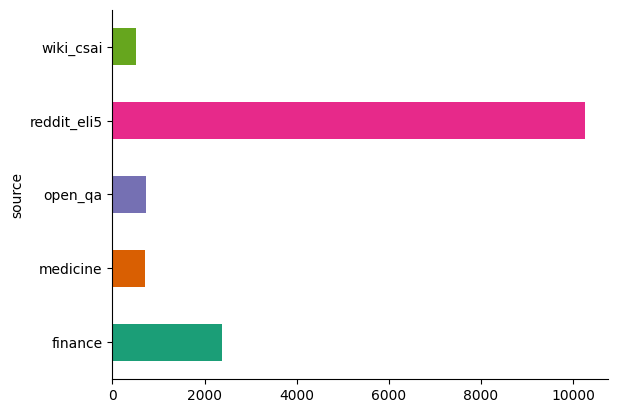

In [94]:
# @title source training

from matplotlib import pyplot as plt
import seaborn as sns
train_df.groupby('source').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [95]:
val_df.head()

,id,question,human_answers,chatgpt_answers,source
0,23877,Are there any supplements to help the brain he...,"[during coiling procedure, developing stroke i...",[It is important to consult with a medical pro...,medicine
1,13778,Can we use this new rail gun technology to sho...,"[Technically speaking , yes we could probably ...",[A rail gun is a device that uses electricity ...,reddit_eli5
2,16156,what an algorithm is . I 've heard about it fo...,[An algorithm is a series of steps to do somet...,[An algorithm is a set of instructions that te...,reddit_eli5
3,5006,Why Facebook may finally have to compromise it...,[So Facebook has grown ( in terms of money ) u...,[\nSure! I'd be happy to help explain this art...,reddit_eli5
4,2100,Refrigeration How does electronic power effect...,[The electricity turns a fan . The fan carries...,[Sure! Refrigeration is a way to keep things c...,reddit_eli5


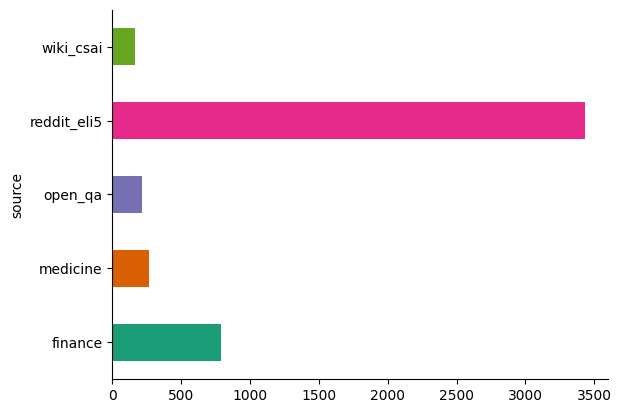

In [96]:
# @title source validation

from matplotlib import pyplot as plt
import seaborn as sns
val_df.groupby('source').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [97]:
'''
avg_human_symbols = train_df['human_answers'].str.len().mean()
avg_chatgpt_symbols = train_df['chatgpt_answers'].str.len().mean()
avg_question_symbols = train_df['question'].str.len().mean

print(f"Average number of symbols in 'human_answers': {avg_human_symbols}")     #problem with [""] at beginning and end of sentence
print(f"Average number of symbols in 'chatgpt_answers': {avg_chatgpt_symbols}")
print(f"Average number of symbols in 'question': {avg_question_symbols}")
'''

avg_human_symbols = train_df['human_answers'].apply(lambda x: sum(len(s) for s in x)).mean()
avg_question_symbols = train_df['question'].apply(lambda x: sum(len(s) for s in x)).mean()
avg_chatgpt_symbols = train_df['chatgpt_answers'].apply(lambda x: sum(len(s) for s in x)).mean()

print(f"Average number of symbols in 'human_answers': {avg_human_symbols}")
print(f"Average number of symbols in 'chatgpt_answers': {avg_chatgpt_symbols}")
print(f"Average number of symbols in 'question': {avg_question_symbols}")


Average number of symbols in 'human_answers': 1644.5503015350878
Average number of symbols in 'chatgpt_answers': 1119.711485745614
Average number of symbols in 'question': 165.12342379385964


In [98]:
import numpy as np
def median_symbols(df, column_name):
    """Calculates the median number of symbols in a column.

    Args:
        df: The input DataFrame.
        column_name: The name of the column to calculate the median for.

    Returns:
        The median number of symbols in the specified column.
    """
    symbol_lengths = df[column_name].apply(lambda x: sum(len(s) for s in x))
    median_length = np.median(symbol_lengths)
    return median_length

# Calculate median symbol lengths for each column
median_human_symbols = median_symbols(train_df, 'human_answers')
median_question_symbols = median_symbols(train_df, 'question')
median_chatgpt_symbols = median_symbols(train_df, 'chatgpt_answers')

# Print the results
print(f"Median number of symbols in 'human_answers': {median_human_symbols}")
print(f"Median number of symbols in 'chatgpt_answers': {median_chatgpt_symbols}")
print(f"Median number of symbols in 'question': {median_question_symbols}")


Median number of symbols in 'human_answers': 1236.0
Median number of symbols in 'chatgpt_answers': 1061.0
Median number of symbols in 'question': 172.0


# Regular Expression Data cleaning

In [99]:
import re

def clean_text(text):
  """Cleans text by removing formatting remnants like \n.

  Args:
    text: The input text string.

  Returns:
    The cleaned text string.
  """
  # Decode bytes-like objects to strings
 # if isinstance(text, bytes):
  #  text = text.decode('utf-8', errors='ignore')  # Decode using UTF-8, ignore errors if any

  #text = re.sub(r'^\["', '', text)  # Remove '["' at the beginning
  #text = re.sub(r"^\['", '', text)  # Remove '[' at the beginning

  # Modified regex to handle both "]" and "']" at the end
  #text = re.sub(r'["\']]$', '', text)

  # Modified regex to handle optional quotes at the beginning
  text = re.sub(r'^\[?["\']?', '', text)
  # Modified regex to handle optional quotes at the end
  text = re.sub(r'["\']?\]?$', '', text)

  # Remove single or double quotes only at the beginning and end
  text = re.sub(r'^["\']', '', text)  # Remove at the beginning
  text = re.sub(r'["\']$', '', text)  # Remove at the end

  #text = re.sub(r'^.(.*).$','\\1',text)  # Cuts the first and last letter



  text = re.sub(r"\\n", " ", text)  # Replaces '\n' with a space
  text = re.sub(r"\\r", " ", text)  # Replaces '\r' with a space
  text = re.sub(r"\\u", " ", text)  # Replaces '\u' with a space

  text = re.sub(r'\\', '', text) # Remove backslashes

    # Remove backslashes (including escaped ones)
  text = re.sub(r'\\\\', '', text)  # Matches escaped backslashes (\\)

  text = re.sub(r"\s+", " ", text)  # Replaces multiple spaces with a single space
  text = text.strip()  # Removes leading/trailing spaces

  return text
'''
# Example usage:
text = "This is a\ntext with\nformatting remnants."
cleaned_text = clean_text(text)
print(cleaned_text)  # Output: This is a text with formatting remnants.
'''

'\n# Example usage:\ntext = "This is a\ntext with\nformatting remnants."\ncleaned_text = clean_text(text)\nprint(cleaned_text)  # Output: This is a text with formatting remnants.\n'

In [100]:
print(train_df.dtypes)

id                 object
question           object
human_answers      object
chatgpt_answers    object
source             object
dtype: object


In [101]:
train_df['human_answers'] = train_df['human_answers'].astype('string')
train_df['chatgpt_answers'] = train_df['chatgpt_answers'].astype('string')

In [102]:
for column in ['human_answers', 'chatgpt_answers']:
    train_df[column] = train_df[column].apply(clean_text) #applyng cleaning function to every element in the dataframe


In [103]:
train_df.head(30)

,id,question,human_answers,chatgpt_answers,source
0,15266,How does lack of sleep lead to bags under the ...,its just the small muscles around the eyes bei...,"Sure! When we sleep, our bodies go through a p...",reddit_eli5
1,10364,Do expensive sunglasses like Oakleys actually ...,The answers here are all over the place . Yes ...,,reddit_eli5
2,11047,Why is Facebook buying Oculus such a bad thing...,"Because typically , when a large , unrelated c...",There are a few reasons why some people are up...,reddit_eli5
3,808,"When sworn to tell "" the truth , the whole tru...","In the US , the [ Fifth Amendment ] ( URL_0 ) ...","In a criminal trial, the defendant is consider...",reddit_eli5
4,2065,What the heck the Pirate Party is . The heck ?...,Every political party in the world has some af...,The Pirate Party is a political party that adv...,reddit_eli5
5,19151,Why does the Brexit cause a fall in crude oil ...,Uncertainty has very far reaching effects. Oil...,"The Brexit, or the United Kingdom's withdrawal...",finance
6,2325,Life Insurance Why is life insurance better th...,Let 's say you have a family . Your family has...,Life insurance is a type of insurance that pay...,reddit_eli5
7,1652,can someone explain how a programing language ...,This has been touched upon in other topics abo...,Sure! I'd be happy to explain how a programmin...,reddit_eli5
8,16989,Why does the u.s . have such large coffee size...,American companies are very competitive with o...,"In the United States, coffee sizes at places l...",reddit_eli5
9,22491,Is there a law or regulation that governs the ...,"In the EU, you might be looking for Directive ...",There are laws and regulations that place limi...,finance


In [104]:
for column in ['human_answers', 'chatgpt_answers']:
    print(f"Column: {column}")  # Print the column name for clarity
    for text in train_df.head(20)[column]:
        print(repr(text))
    print("-" * 20)  # Print a separator between columns

Column: human_answers
'its just the small muscles around the eyes being tired . Those fuckers move almost constantly throughout the day , so when they get tired they really look tired .\', \'Bags under your eyes can also be increased in size if you eat a lot of salt thru the day .\', "Actually , it \'s kind of the other way around . The skin on your face gets pale from a lack of sleep or just general fatigue , and as a result , it seems as if you have these dark circles under your eyes .'
'The answers here are all over the place . Yes , you are paying for name / marketing , but you are also paying for correctly oriented polarized lenses . There is also UV protection , but you can find that on cheap pairs too . What makes Oakleys preferable is that the polarized lenses ( which reduce glare ) are oriented in the same direction . If they are not oriented the same direction , your brain will have difficulty correcting the slight distortions , which will eventually make it uncomfortable to 

# Mounting to Google Drive

In [27]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
train_df.to_csv('/content/drive/MyDrive/train_df.csv', index=False)

In [30]:
# Load the CSV file from Google Drive into a pandas DataFrame
train_df_loaded = pd.read_csv('/content/drive/MyDrive/train_df.csv')

# Now you can work with the train_df_loaded DataFrame
#print(train_df_loaded.head())
train_df_loaded.head()

      id                                           question  \
0  15299  How come in the American justice system most p...   
1   6104  how can my smoke detector not be set off by my...   
2  12169  How come you ca n't give blood in the US if yo...   
3   9344  Why are license plates blurred out on TV when ...   
4  13368  Why are n't blimps and zeppelins more popular ...   

                                       human_answers  \
0  The death penalty is irreversible . If someone...   
1  Smoke detectors work by having a radioactive s...   
2  There are many concerns besides the plague . M...   
3  They want to protect the privacy of the vehicl...   
4  They 're really , really , really , really slo...   

                                     chatgpt_answers       source  
0  In the United States, the death penalty is a l...  reddit_eli5  
1  Smoke detectors are designed to detect certain...  reddit_eli5  
2  There are certain restrictions on who can dona...  reddit_eli5  
3  There are

,id,question,human_answers,chatgpt_answers,source
0,15299,How come in the American justice system most p...,The death penalty is irreversible . If someone...,"In the United States, the death penalty is a l...",reddit_eli5
1,6104,how can my smoke detector not be set off by my...,Smoke detectors work by having a radioactive s...,Smoke detectors are designed to detect certain...,reddit_eli5
2,12169,How come you ca n't give blood in the US if yo...,There are many concerns besides the plague . M...,There are certain restrictions on who can dona...,reddit_eli5
3,9344,Why are license plates blurred out on TV when ...,They want to protect the privacy of the vehicl...,There are a few reasons why license plates mig...,reddit_eli5
4,13368,Why are n't blimps and zeppelins more popular ...,"They 're really , really , really , really slo...",Blimps and zeppelins are not as popular as oth...,reddit_eli5


# Dataset

# Data module

# Neuer Abschnitt